In [14]:
from Models.GlassBox.ebm.ebm_class import EBM_class
from InterpretabilityByDesign.EBMExplanator import EBMExplanator
import matplotlib.pyplot as  plt
import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

In [2]:
EBM_parameter = dict(
    learning_rate= [0.005, 0.01, 0.02, 0.03],
    min_samples_leaf=[2, 3, 4, 5],
    max_leaves=[2, 3, 4],
    max_bins=[5, 7, 10],
    outer_bags=[8, 10],
)
gridsearch_parameters = dict(
    path="./../../../outputs/scores/",
    name="0",
    nDCG_at=15
)

# Grid-search

In [3]:
gs = EBM_class(**gridsearch_parameters)

In [4]:
best_ = gs.grid_search(hyperparameters=EBM_parameter)
gs.save_model(best_[0], name="EBMReg")

Finding the best model: 100%|██████████| 288/288 [15:08<00:00,  3.15s/it, nDCG_15_at=0.983]


# Metric evaluation

In [5]:
best_model = gs.load_model(name="./saved_models/EBMReg")

In [11]:
best_model.to_json("h.json")

C:\Users\Andrea\anaconda3\envs\FindHR\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:1555: UserWarning: The function to_json is in beta. The JSON format may change in a future version.
  warn(


In [7]:
# nDCG on test-set
nDCG_train = gs.eval_model(model=best_model, df=gs.train, nDCG_at=[1,10,15])
nDCG_valid = gs.eval_model(model=best_model, df=gs.valid, nDCG_at=[1,10,15])
nDCG_test = gs.eval_model(model=best_model, df=gs.test, nDCG_at=[1,10,15])

display(pd.DataFrame([nDCG_train,nDCG_valid,nDCG_test],index=["Training","Validation","Test"]))

,nDCG@1,nDCG@10,nDCG@15
Training,0.9361,0.9597,0.9674
Validation,0.9376,0.9757,0.9825
Test,0.9270,0.9647,0.9735


# Explanation

In [22]:
explanator = EBMExplanator(model_path="./saved_models/EBMReg",
                           dataset_path=f"./../../../outputs/scores/0_dataset_tr.csv")

lists_= explanator.show_piecewise_functions()

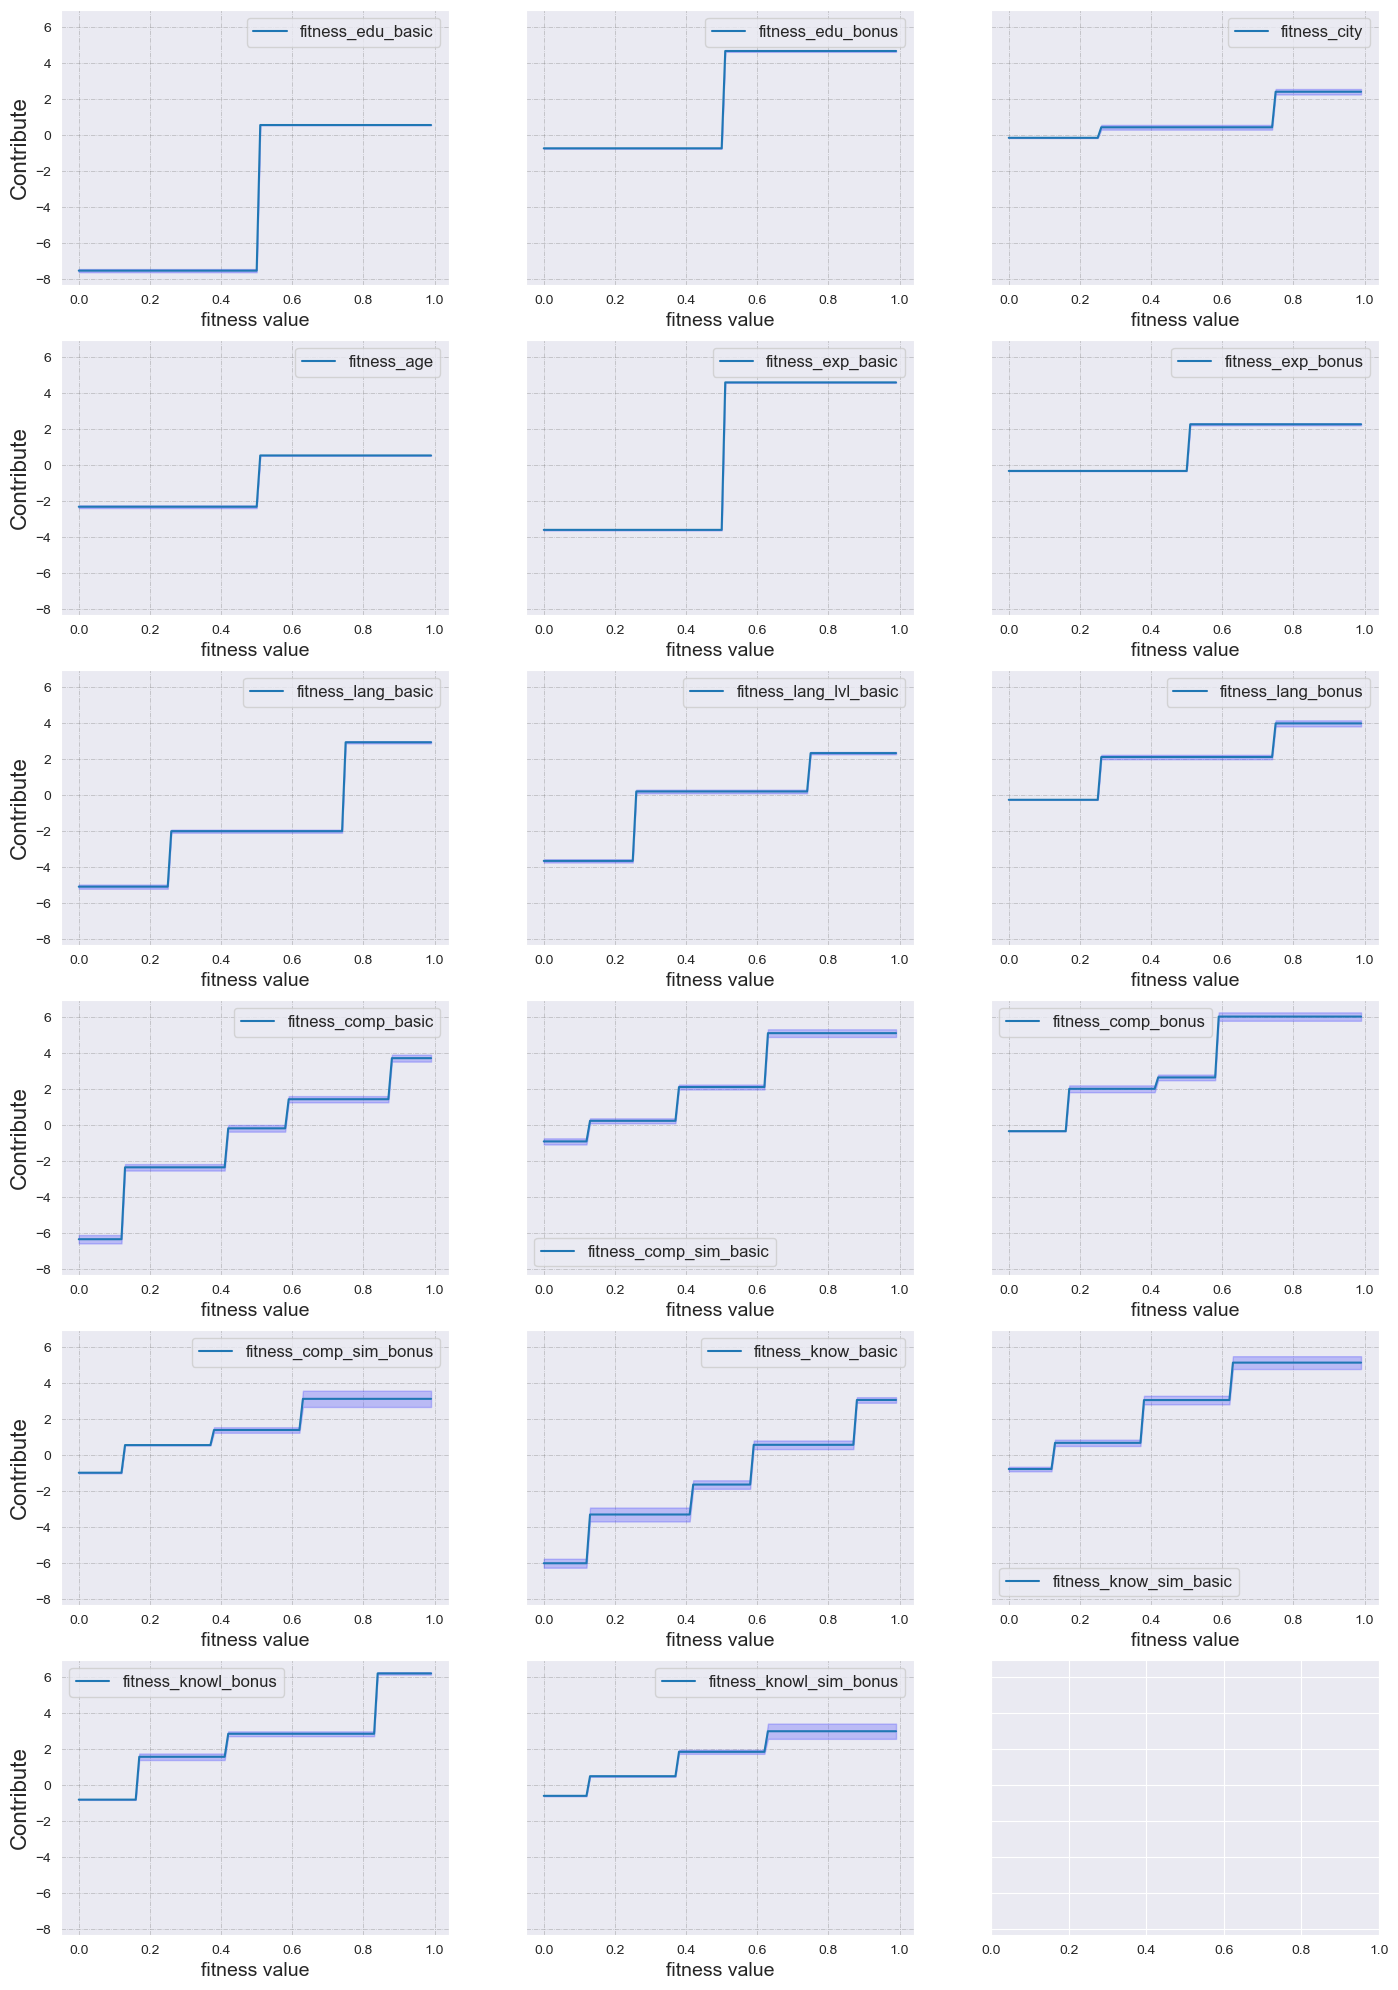

In [23]:
f, axs = plt.subplots(ncols=3,nrows=6,figsize=(17, 25),sharey=True)
for i, (name,fun) in enumerate(lists_):
    sns.lineplot(x="x",y="y",data=fun, label=name, ax=axs[int(i/3)][i%3])
    axs[int(i/3)][i%3].fill_between(fun['x'], fun['lower'], fun['upper'], color='#4B4BFF', alpha=0.3)
    axs[int(i/3)][i%3].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
    axs[int(i/3)][i%3].set_xlabel("fitness value", fontsize=14)
    axs[int(i/3)][i%3].set_ylabel("Contribute", fontsize=16)
    axs[int(i/3)][i%3].legend(fontsize=12)
plt.show()